# 0. Imports and settings

In [1]:
# Load libraries
print("Loading libraries")
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep
from collections import namedtuple
import vector
print("Libraries loaded")

# Set mpl settings
plt.style.use(mplhep.style.CMS)
print("CMS MPL style set")

Loading libraries
Libraries loaded
CMS MPL style set


# 1. Global classes and functions

In [2]:
def readData(path, printBranches=False):
    data = uproot.open(path)['Events']
    
    if printBranches:
        for branch in data: print(branch)
        return data
    else: return data

In [35]:
dat = readData("/users/wq22321/jetStudies/CMSSW_12_5_2_patch1/src/FastPUPPI/NtupleProducer/python/perfNano.root", printBranches=True)

<TBranch 'run' at 0x7f90086ca3d0>
<TBranch 'luminosityBlock' at 0x7f90086cac10>
<TBranch 'event' at 0x7f90086bf4c0>
<TBranch 'bunchCrossing' at 0x7f90086bfbb0>
<TBranch 'nGenParticlesCands' at 0x7f90086c23a0>
<TBranch 'GenParticlesCands_pt' at 0x7f90086c2b50>
<TBranch 'GenParticlesCands_eta' at 0x7f90086c7340>
<TBranch 'GenParticlesCands_phi' at 0x7f90086c7af0>
<TBranch 'GenParticlesCands_mass' at 0x7f90086d02e0>
<TBranch 'GenParticlesCands_charge' at 0x7f90086d0a90>
<TBranch 'GenParticlesCands_pdgId' at 0x7f90086d1280>
<TBranch 'nl1tLayer2DeregionizerCands' at 0x7f90086d1a30>
<TBranch 'l1tLayer2DeregionizerCands_pt' at 0x7f90086d4220>
<TBranch 'l1tLayer2DeregionizerCands_eta' at 0x7f90086d49d0>
<TBranch 'l1tLayer2DeregionizerCands_phi' at 0x7f90086d71c0>
<TBranch 'l1tLayer2DeregionizerCands_mass' at 0x7f90086d7970>
<TBranch 'l1tLayer2DeregionizerCands_charge' at 0x7f90086d8160>
<TBranch 'l1tLayer2DeregionizerCands_pdgId' at 0x7f90086d8910>
<TBranch 'nAK8Jets' at 0x7f90086dc100>
<TBran

In [79]:
class Event:

    Candidate = namedtuple("Candidate", "pt phi eta mass")

    def __init__(self, branch, event, data = dat, getProps=True, cut=15, **kwargs):

        self.branch = branch
        self.event = event
        self.nJets = data[f"n{branch}Jets"].array()[event]
        self.jetProps = {f"jet{jetIdx}":{} for jetIdx in range(self.nJets)}
        if getProps:
            self.getJetAxis()
            self.getJetCandidates()
            self.getJetSeed()
            self.pTcut(cut=cut)    # cut = 10 as gen jet pt cut is 15 so 10 to be safe

        for key, value in kwargs.items(): setattr( self, key, value )    # Set attributes for whatever kwargs were passed


    def getPUPPIcands(self, data=dat):
        puppiCands = list( map(Event.Candidate, data["l1tLayer2DeregionizerCands_pt"].array()[self.event], data["l1tLayer2DeregionizerCands_phi"].array()[self.event], data["l1tLayer2DeregionizerCands_eta"].array()[self.event], data["l1tLayer2DeregionizerCands_mass"].array()[self.event]) )
        self.puppiCands = puppiCands
        return self.puppiCands


    def getGenCands(self, data=dat):
        genCands = list( map(Event.Candidate, data["GenParticlesCands_pt"].array()[self.event], data["GenParticlesCands_phi"].array()[self.event], data["GenParticlesCands_eta"].array()[self.event], data["GenParticlesCands_mass"].array()[self.event]) )
        self.genCands = genCands
        return self.genCands


    def getJetAxis(self, data=dat):
        
        pt, phi, eta, mass = data[self.branch+"Jets_pt"].array()[self.event], data[self.branch+"Jets_phi"].array()[self.event], data[self.branch+"Jets_eta"].array()[self.event], data[self.branch+"Jets_mass"].array()[self.event]
        axes = tuple( map( Event.Candidate, pt, phi, eta, mass ) )
        
        for jetIdx in range(self.nJets):
            self.jetProps[f"jet{jetIdx}"]["axis"] = axes[jetIdx]

        return self.jetProps
        

    def getJetSeed(self):
        
        for jetIdx in range(self.nJets):
            try:
                constituents = self.jetProps[f"jet{jetIdx}"]["cands"]
            except KeyError:    # If cands doesnt exist, get candidates then seed
                _ = self.getJetCandidates()
                constituents = self.jetProps[f"jet{jetIdx}"]["cands"]

            pts, etas, phis, mass = zip(*constituents)
            self.jetProps[f"jet{jetIdx}"]["seed"] = constituents[pts.index(max(pts))]
        
        return self.jetProps


    def getJetCandidates(self, data=dat):
        for jetIdx in range(self.nJets):
            self.jetProps[f"jet{jetIdx}"]["cands"] = []
            
            candIdx = 0
            while True:
                try:
                    pt, phi, eta, mass = data[f"{self.branch}Jets_dau{candIdx}_pt"].array()[self.event], data[f"{self.branch}Jets_dau{candIdx}_phi"].array()[self.event], data[f"{self.branch}Jets_dau{candIdx}_eta"].array()[self.event], data[f"{self.branch}Jets_dau{candIdx}_mass"].array()[self.event]
                    self.jetProps[f"jet{jetIdx}"]["cands"].append( Event.Candidate(pt = pt[jetIdx], phi = phi[jetIdx], eta = eta[jetIdx], mass = mass[jetIdx]) ) if pt[jetIdx] != -1 else None            
                    candIdx += 1
                except: break

        return self.jetProps


    def getJetMass(self, method="calc", r=0.8):

        if method=="lorentz":
            for jet, props in self.jetProps.items():
                constituents = props["cands"]

                jet_vector = vector.obj(pt=0,eta=0,phi=0,m=0)
                for p in constituents:
                    jet_vector += vector.obj(pt=p.pt, eta=p.eta, phi=p.phi, m=p.mass)
                
                self.jetProps[jet]["calcedProps"] = jet_vector
            return self.jetProps


        if method=="calc":
            for jet, props in self.jetProps.items():
                axisPt, axisPhi, axisEta, axisMass = props["axis"]
                seedPt, seedPhi, seedEta, seedMass = props["seed"]

                p1_tot = 0
                p1x_tot = 0
                p1y_tot = 0
                p1z_tot = 0

                for constituent in props["cands"]:
                    constitPt, constitPhi, constitEta, constitMass = constituent
                    if constitPhi - seedPhi > r  :  constitPhi -= 2*np.pi #phiDist = constitPhi - axisPhi - 2*np.pi
                    if constitPhi - seedPhi < -r :  constitPhi += 2*np.pi #phiDist = constitPhi - axisPhi + 2*np.pi

                    etaDist, phiDist = constitEta - axisEta, constitPhi - axisPhi
                    dist2 = etaDist**2 + phiDist**2

                    p1_tot  += constitPt
                    p1x_tot += constitPt * etaDist
                    p1y_tot += constitPt * phiDist
                    p1z_tot += constitPt * (1 - (dist2 / 2))
                
                self.jetProps[jet]["mass"] = p1_tot**2 - p1x_tot**2 - p1y_tot**2 - p1z_tot**2

            return self.jetProps

    
    def plotEvent(self, centreOn = "seed", r=0.8, plotPUPPI=True, plotGen=False):
        fig, ax = plt.subplots(figsize=(12, 12))
        
        marker="x"
        markerCol = "black"
        constituentsScale = 20
        axisScale = 100
        puppiCandScale = constituentsScale - 1

            # Plot PUPPI candidates
        if plotPUPPI == True:
            if hasattr(self, "puppiCands") == False: _ = self.getPUPPIcands()
            puppiCandPts, puppiCandPhis, puppiCandEtas, puppiCandMasses = zip(*self.puppiCands)
            plt.scatter(puppiCandEtas, puppiCandPhis, s=puppiCandScale*np.log(np.array(puppiCandPts)+1), c=markerCol, label="PUPPI candidates")
        
        if plotGen:
            # Plot gen particles
            if hasattr(self, "genCands") == False: _ = self.getGenCands()
            genParts = []
            for p in self.genCands:
                if p.mass > 70:
                    genParts.append(p)
            genCandPts, genCandPhis, genCandEtas, genCandMasses = zip(*genParts)
            plt.scatter(genCandEtas, genCandPhis, s=puppiCandScale*np.log(np.array(genCandMasses)+1), marker="^", c="black", label="Gen particles")

        # Make sure jetProps has required data
        try: self.jetProps["jet0"]["cands"]
        except KeyError: _ = self.getJetCandidates()

        if centreOn == "seed":
            try: self.jetProps["jet0"][centreOn]
            except KeyError: _ = self.getJetSeed()

        # Plot jets
        for jet in self.jetProps.keys():
            cands = self.jetProps[jet]["cands"]
            axis = self.jetProps[jet]["axis"]

            try: mass = self.jetProps[jet]["calcedProps"].mass
            except:
                _ = self.getJetMass(method="lorentz")
                mass = self.jetProps[jet]["calcedProps"].mass

            pts, phis, etas, masses = zip(*cands)
            jetPt, jetPhi, jetEta, jetMass = axis

            # Plot constituents of the jet
            plt.scatter(etas, phis, s=constituentsScale*np.log(np.array(pts)+1), label = f"{jet} pT = {np.round(jetPt, 2)} GeV\nMass = {np.round(mass, 2)} GeV")
            # Plot an X on the jet axis
            plt.scatter(jetEta, jetPhi, s=axisScale*np.log(np.array(jetPt)+1), c=markerCol, marker=marker)    # Note +1 on the pt ensures we dont take log < 1

            if centreOn == "jet":    # Plot circle around the jet axis
                ax.add_patch(plt.Circle((jetEta, jetPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                # Phi wrapping
                if jetPhi + r > np.pi:
                    ax.add_patch(plt.Circle((jetEta, -2*np.pi+jetPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--"))
                if jetPhi - r < -np.pi:
                    ax.add_patch(plt.Circle((jetEta, 2*np.pi+jetPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--"))            

            elif centreOn == "seed":    # Plot circle around the seed
                seedPt, seedPhi, seedEta, seedMass = self.jetProps[f"{jet}"]["seed"]
                ax.add_patch(plt.Circle((seedEta, seedPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                # Phi wrapping
                if seedPhi + r > np.pi:
                    ax.add_patch(plt.Circle((seedEta, -2*np.pi+seedPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--"))
                if seedPhi - r < -np.pi:
                    ax.add_patch(plt.Circle((seedEta, 2*np.pi+seedPhi), r, edgecolor=markerCol, facecolor='none', linewidth=1, linestyle="--"))            

        # Format the graph
        ax.set_xlabel('η')    # Set x and y labels
        ax.set_ylabel('ϕ')    #
        ax.set_ylim((-np.pi, np.pi))
        ax.set_xlim((-5, 5))
        ax.set_aspect('equal', 'box')
        ax.set_title(f"{self.branch} jets. Event = {self.event}")
        #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(self.event), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
        ax.legend()
        ax.grid()
        plt.show()


    def pTcut(self, cut=15):
        for jet, props in list(self.jetProps.items()):
            if props["axis"].pt < cut: self.jetProps.pop(jet)

In [86]:
gen = Event("Gen", 0)

In [84]:
sc8 = Event("SC8", 1, cut=30)

In [73]:
scCands = sc.getGenCands()

In [55]:
genParts

[Candidate(pt=205.50209045410156, phi=-0.9799920916557312, eta=0.2742151916027069, mass=124.99600982666016),
 Candidate(pt=205.50209045410156, phi=2.1616005897521973, eta=-0.016580820083618164, mass=92.22806549072266),
 Candidate(pt=223.5666961669922, phi=-1.0464396476745605, eta=0.20075201988220215, mass=124.99600982666016),
 Candidate(pt=185.23207092285156, phi=2.2581324577331543, eta=-0.2479569911956787, mass=92.22806549072266),
 Candidate(pt=221.49411010742188, phi=-1.0849621295928955, eta=0.2108117789030075, mass=124.99600982666016),
 Candidate(pt=187.2320098876953, phi=2.2814788818359375, eta=-0.2555179297924042, mass=92.22806549072266),
 Candidate(pt=226.44326782226562, phi=-1.0894137620925903, eta=0.22522836923599243, mass=124.99600982666016),
 Candidate(pt=181.5446014404297, phi=2.29573655128479, eta=-0.28810444474220276, mass=92.22806549072266),
 Candidate(pt=226.45565795898438, phi=-1.091607689857483, eta=0.22522537410259247, mass=124.99600982666016),
 Candidate(pt=181.59886

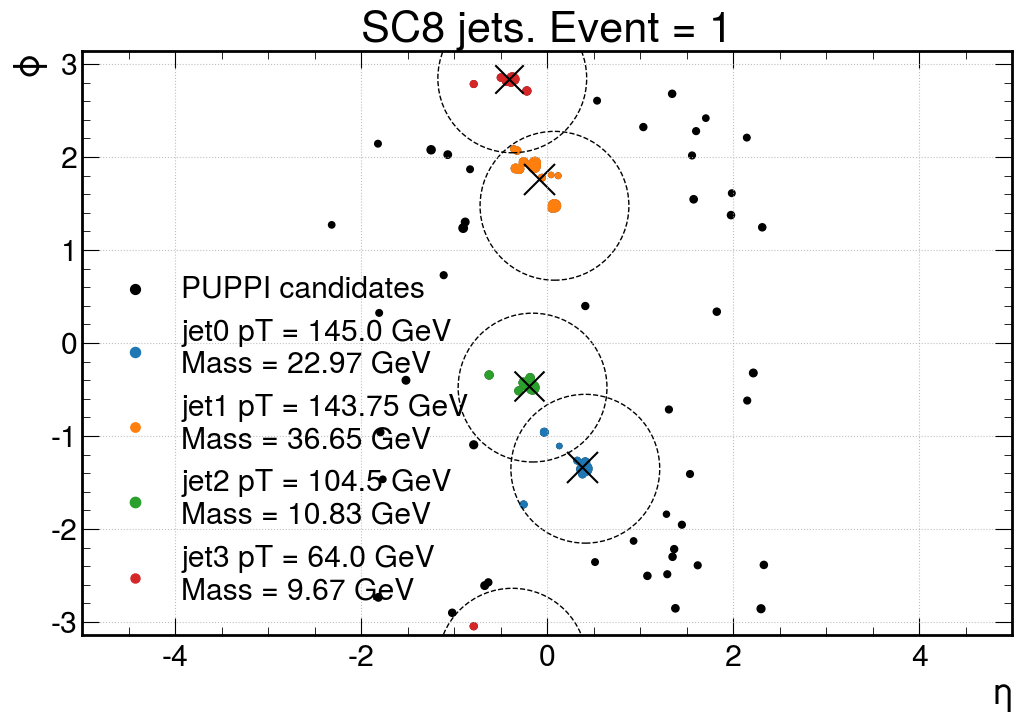

In [85]:
sc8.plotEvent(centreOn="seed", r=0.8, plotPUPPI=True, plotGen=False)

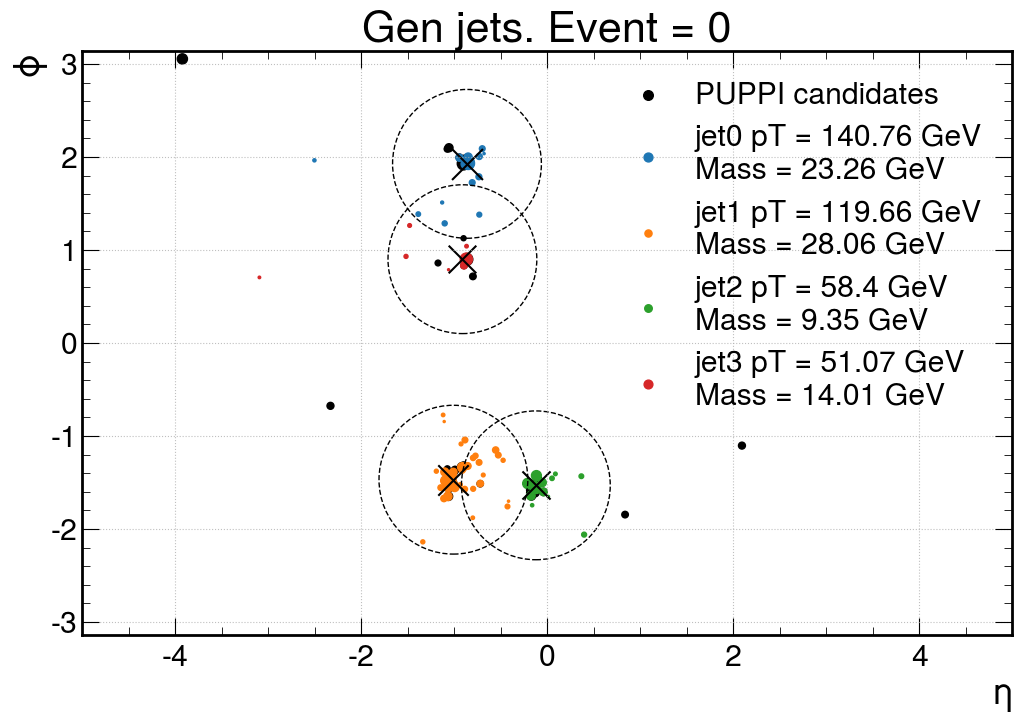

In [87]:
gen.plotEvent(centreOn="jet", plotPUPPI=True, plotGen=False)

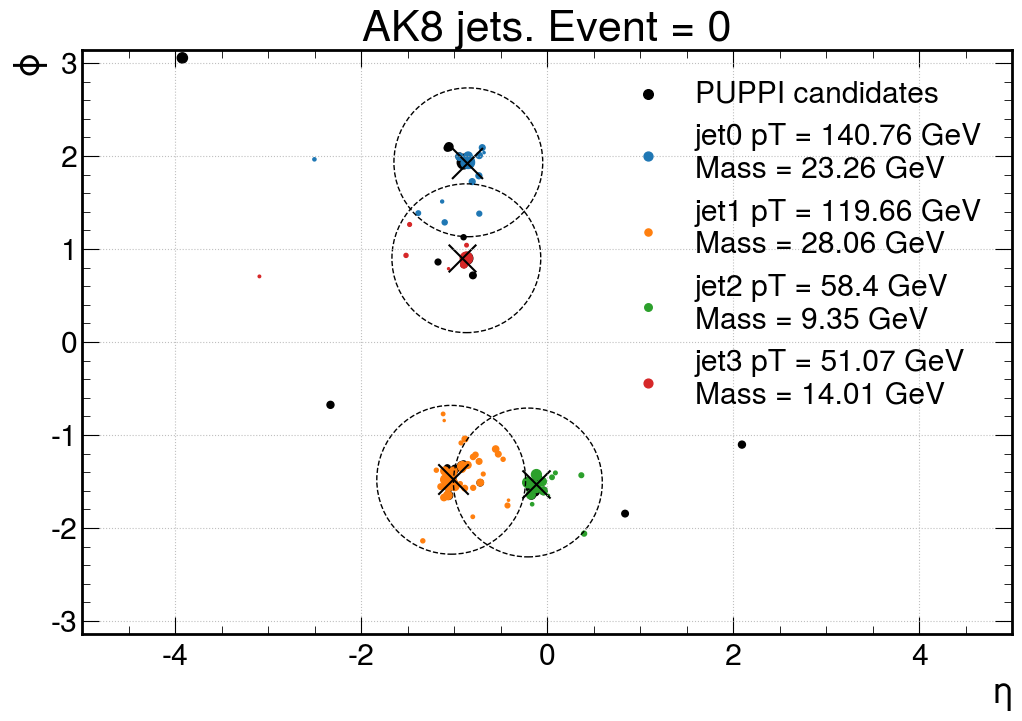

In [18]:
ak8.plotEvent(centreOn="seed", r=0.8)


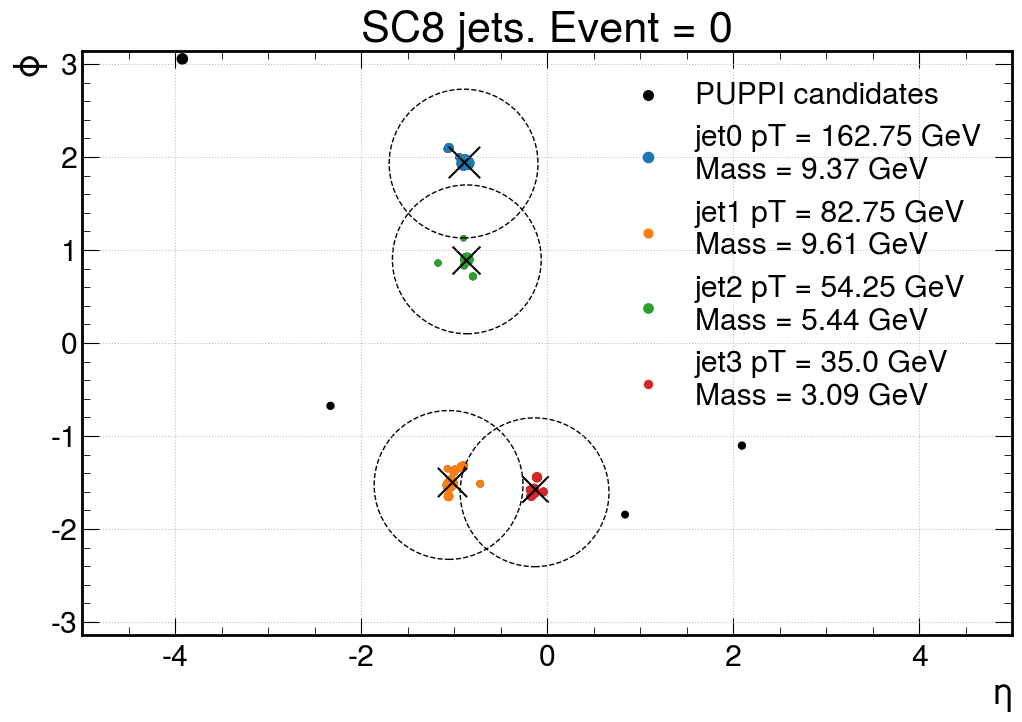

In [19]:
sc8.plotEvent(centreOn="seed", r=0.8)

In [23]:
ak8.jetProps["jet0"]["cands"]

[Candidate(pt=52.921173095703125, phi=1.9316657781600952, eta=-0.847721517086029, mass=0.13956999778747559),
 Candidate(pt=23.8663387298584, phi=1.9287707805633545, eta=-0.8456681370735168, mass=0.13956999778747559),
 Candidate(pt=18.062824249267578, phi=1.949007511138916, eta=-0.8526391386985779, mass=0.13956999778747559),
 Candidate(pt=17.679912567138672, phi=1.93788480758667, eta=-0.8405892848968506, mass=0.0),
 Candidate(pt=8.113370895385742, phi=1.9235451221466064, eta=-0.8760252594947815, mass=0.4936800003051758),
 Candidate(pt=4.519548416137695, phi=1.9985802173614502, eta=-0.8499434590339661, mass=2.230201658903752e-07),
 Candidate(pt=4.202728271484375, phi=1.9310237169265747, eta=-0.8546650409698486, mass=1.0323827126512697e-07),
 Candidate(pt=2.7861454486846924, phi=1.9913674592971802, eta=-0.9427701234817505, mass=0.4936800003051758),
 Candidate(pt=1.5914472341537476, phi=2.0050556659698486, eta=-0.7304792404174805, mass=0.13956999778747559),
 Candidate(pt=1.4535348415374756

In [24]:
sc8.jetProps["jet0"]["cands"]

[Candidate(pt=5.0, phi=2.0987584590911865, eta=-1.0559241771697998, mass=0.5),
 Candidate(pt=2.0, phi=2.0856683254241943, eta=-1.0733774900436401, mass=0.0),
 Candidate(pt=77.25, phi=1.9285888671875, eta=-0.8988445401191711, mass=0.5),
 Candidate(pt=53.75, phi=1.9329521656036377, eta=-0.8552113175392151, mass=0.12999999523162842),
 Candidate(pt=22.0, phi=1.9634953737258911, eta=-0.8813912868499756, mass=0.0),
 Candidate(pt=2.75, phi=1.994038701057434, eta=-0.9424777626991272, mass=0.12999999523162842)]

# 2. Plotting functions

In [110]:
def jetPlotter(Ev, jets, jetCap, r=0.4, jetCircle=True):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(cands.eta[Ev], cands.phi[Ev], c=np.log(cands.pt[Ev]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
    
    for jetType in jets:    # Iterate over the different types of jets
        eta, phi, pt = jetType.eta[Ev][:jetCap], jetType.phi[Ev][:jetCap], jetType.pt[Ev][:jetCap]
        seed_eta, seed_phi, seed_pt = jetType.seeds.eta[Ev], jetType.seeds.phi[Ev], jetType.seeds.pt[Ev]
        name, mark, col = jetType.name, jetType.marker, jetType.colour
        
        ax.scatter(eta, phi, s=30*np.log(pt), label=name, marker=mark, edgecolors=col, facecolor='none')    # Plot the jets up to the jet cap
        for i, _ in enumerate(pt):    # Iterate over the jets
            if jetCircle:
                ax.add_patch(plt.Circle((eta[i], phi[i]), r, edgecolor=jetType.colour, facecolor='none', linewidth=1, linestyle="--"))    # Add circle around given jet to the current axis
                if phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((eta[i], -2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((eta[i], 2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
            else:    # Places the circle around the seed
                ax.add_patch(plt.Circle((seed_eta[i], seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                """ Phi wrapping """
                if seed_phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], -2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if seed_phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], 2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
    
    ax.set_xlabel('η')    # Set x and y labels
    ax.set_ylabel('ϕ')    #
    ax.set_ylim((-np.pi, np.pi))
    ax.set_xlim((-5, 5))
    ax.set_aspect('equal', 'box')
    ax.set_title("Level 1 jets. Event = {}".format(Ev))
    #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    ax.legend()
    return ax

# 3. Wide cone Jets

In [38]:
ntuple = "~/cernbox/wideCone/wideConeSig.root"
sig = readData(ntuple, printBranches=True)

<TBranch 'run' at 0x7f9a405c69b0>
<TBranch 'luminosityBlock' at 0x7f9a405c65f8>
<TBranch 'event' at 0x7f9a405a0dd8>
<TBranch 'bunchCrossing' at 0x7f9a405544e0>
<TBranch 'nL1PFCands' at 0x7f9a40554ac8>
<TBranch 'L1PFCands_pt' at 0x7f9a405580f0>
<TBranch 'L1PFCands_eta' at 0x7f9a405586d8>
<TBranch 'L1PFCands_phi' at 0x7f9a40558cc0>
<TBranch 'L1PFCands_mass' at 0x7f9a4055f2e8>
<TBranch 'L1PFCands_charge' at 0x7f9a4055f8d0>
<TBranch 'L1PFCands_pdgId' at 0x7f9a4055fef0>
<TBranch 'L1PFCands_puppiWeight' at 0x7f9a40567550>
<TBranch 'nL1PuppiCands' at 0x7f9a40567b38>
<TBranch 'L1PuppiCands_pt' at 0x7f9a4056e160>
<TBranch 'L1PuppiCands_eta' at 0x7f9a4056e748>
<TBranch 'L1PuppiCands_phi' at 0x7f9a4056ed30>
<TBranch 'L1PuppiCands_mass' at 0x7f9a40576358>
<TBranch 'L1PuppiCands_charge' at 0x7f9a40576940>
<TBranch 'L1PuppiCands_pdgId' at 0x7f9a40576f60>
<TBranch 'L1PuppiCands_puppiWeight' at 0x7f9a4057c5c0>
<TBranch 'nl1tLayer2DeregionizerCands' at 0x7f9a4057cba8>
<TBranch 'l1tLayer2DeregionizerCan

In [9]:
cands = Candidates(data=sig)

In [10]:
jetParams = {
    "wideHSC" : ("red", "^"),
    "scPuppi" : ("blue", "X")
}

wideHSC, sc = jetConstructor(data=sig, jetParams=jetParams)

Loading wideHSC
Loading scPuppi


<AxesSubplot:title={'center':'Level 1 jets. Event = 1'}, xlabel='η', ylabel='ϕ'>

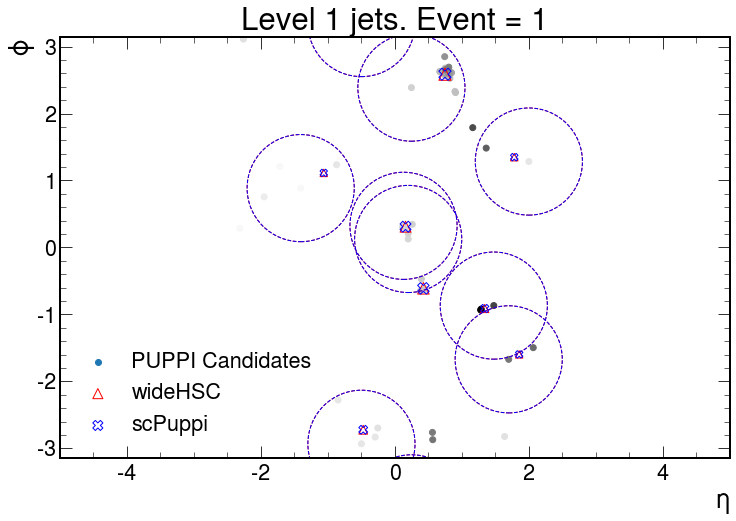

In [37]:
jetPlotter(Ev=1, jets=[wideHSC, sc], jetCap=50, r=0.8, jetCircle=False)

# 4. Regular Jets

In [ ]:
path = "~/cernbox/outputFiles/seedSize/TTbar/TTbarTrimmed.root"
data = uproot.open(path)['Events']

## Histogrammer illustrator

In [ ]:
ev=7
cap=5
fig, ax = plt.subplots(figsize=(12, 12))
#fig, ax = plt.subplots()
ax.hist2d(
    cands["eta"][ev], cands["phi"][ev],
    weights=np.log(cands["pt"][ev]),
    bins=50,
    cmap="Reds"
#    range=[ (-5, 5), (-np.pi, np.pi) ]
)

def Square(ax):
    ax.add_patch(plt.Rectangle((0,0), 10, 10))
    
ax.add_patch(plt.Rectangle((-0.5, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-0.75, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-1.0, -2.10), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
    
#ax.set_title("Phase 1 Histogrammer")
mplhep.cms.label(label="Phase 1 histogrammer".format(), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
ax.set_xlabel("η\eta"); ax.set_ylabel("ϕ\phi")

ax.scatter(gen["eta"][ev][:cap], gen["phi"][ev][:cap], s=30*np.log(gen["pt"][ev][:cap]), marker="X", edgecolors="black", facecolor='none', label="Generator jets")
ax.set_xlabel('η\eta')    # Set x and y labels
ax.set_ylabel('ϕ\phi')    #
ax.set_ylim((-np.pi, np.pi))
ax.set_xlim((-5, 5))
ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

## Cutting jets on pT

In [ ]:
def ptCutter(jetDict, cut=25):
    filtArray = jetDict["pt"][:] > cut
    jetDict["pt"] = jetDict["pt"][:][filtArray]
    jetDict["eta"] = jetDict["eta"][:][filtArray]
    jetDict["phi"] = jetDict["phi"][:][filtArray]
    return jetDict

In [ ]:
sc_cut = ptCutter(sc)
hsc_cut = ptCutter(hsc)
hist_cut = ptCutter(hist)

## Plotting the jets

In [ ]:
plotter([one, gen], jetCap=8, Ev=1000, jetCircle=True)

## Generating data

In [ ]:
def seedAxisDiff(jetType, allEvs=True, distThresh=5):

    jetTypeNEW = jetType
    anoms = []
    nEvents = len(jetTypeNEW["pt"]) if allEvs == True else allEvs
    for ev in range(nEvents):
        jetEta = jetTypeNEW["eta"][ev]
        seedEta = jetTypeNEW["seeds"]["eta"][ev]

        jetPhi = jetTypeNEW["phi"][ev]
        seedPhi = jetTypeNEW["seeds"]["phi"][ev]
        
        distances = ((jetEta - seedEta)**2 + (jetPhi - seedPhi)**2)**0.5
        # distancesTruthTable = distances > distThresh
        # passedJetsIdx = [idx for idx, logic in enumerate(distancesTruthTable) if logic]
        # passedDistances = distances[distancesTruthTable]
        
        # for dist in passedJetsIdx:
        anoms.append(distances > distThresh)
        #anoms = np.append(anoms, [distances > distThresh], axis=0)
            #jetType["seeds"]["anom"].append(distances > distThresh)

    jetTypeNEW["seeds"]["anom"] = anoms
    
    return jetTypeNEW

In [ ]:
hsc

In [ ]:
hsc2 = seedAxisDiff(hsc, allEvs = 100, distThresh=0.2)

In [ ]:
hsc2["seeds"]["anom"]

In [ ]:
plotter([gen, hsc, nine], Ev=1034, jetCap=8, jetCircle=False)

In [ ]:
def pairer(gen, jet, ev, r=0.4):
    """
    - Get a KDTree containing every sc jet
    - In a loop over every gen jet, query the tree with the gen jet
    - This will return the nearest sc jet to the gen jet
    """

    res = {
        "genXY"     : [],
        "jetXY"     : [],
        "seedXY"    : [],
        "dist"      : [],
        "eta_dist"  : [],
        "phi_dist"  : [],
        "pt"        : [],
        "unpaired"  : 0,
        "totalJets" : 0
    }
    
    jetXY, jetPt = list( zip(jet["seeds"]["eta"][ev], jet["seeds"]["phi"][ev]) ), jet["pt"][ev]
    genXY, genPt = list( zip(gen["eta"][ev], gen["phi"][ev]) ), gen["pt"][ev]
    if len(jetXY) == 0:
        res["unpaired"] = len(genPt)
        res["genXY"] = genXY
        return res
    
    jetKDT = KDTree(jetXY)
    for idx, genJet in enumerate(genXY):
        res["totalJets"] += 1
        dist, order = jetKDT.query(genJet)
        if dist < r:
            res["genXY"].append(genJet)
            res["jetXY"].append(jetXY[order])
            res["dist"].append(dist)
            res["pt"].append((genPt[idx] - jetPt[order]) / genPt[idx])
            res["eta_dist"].append(genJet[0] - jetXY[order][0])
            res["phi_dist"].append(genJet[1] - jetXY[order][1])
        else:
            res["unpaired"] += 1

    return res

In [ ]:
def datCalc(jetAlgos, quant, gen=gen, events=len(gen["pt"])):
    assert quant in ["dist", "pt", "unpaired", "totalJets", "eta_dist", "phi_dist"]
    
    if quant == "unpaired" or quant == "totalJets":
        dic = {algo["name"]:0 for algo in jetAlgos}
    else:
        dic = {algo["name"]:[] for algo in jetAlgos}
    
    for algo in jetAlgos:
        for event in range(events):
            dat = pairer(gen=gen, jet=algo, ev=event)
            dic[algo["name"]] += dat[quant]

    return dic

In [ ]:
pts = datCalc([hsc, three, five, seven, nine], quant="pt", events=10000)

In [ ]:
histPlotter(pts)

In [ ]:
dists = datCalc([hsc, three, five, seven, nine], quant="dist", events=10000)

In [ ]:
dists

In [ ]:
for i in dists:
    print(i)

In [ ]:
def histPlotter(var):

    binning=np.linspace(-0.4, 0.4, 100)
    for i in var:
        plt.hist(
            var[i],
            bins=binning,
            histtype="step",
            label=i,
            density=True
        )
    plt.legend()
    plt.xlabel("$\phi$")
    plt.title("$\phi$ seed resolution for different seed sizes")
    plt.grid()
    plt.show()

In [ ]:
eta_dist_dat = datCalc([hsc, three, five, seven, nine], quant="eta_dist", events=10000)

In [ ]:
histPlotter(eta_dist_dat)

In [ ]:
phi_dist_dat = datCalc([hsc, three, five, seven, nine], quant="phi_dist", events=10000)

In [ ]:
histPlotter(phi_dist_dat)

In [ ]:
unpairedNums = datCalc([hsc, three, five, seven, nine], quant="unpaired", events=10000)

In [ ]:
total_jets = datCalc([hsc, three, five, seven, nine], quant="totalJets", events=10000)

## Plotting data

In [ ]:
def resPlotter(data, nbins=100, quant=""):
    plt.figure(figsize=(10,6))
    
    if quant== "dist":
        binning = np.linspace(0, 0.4, nbins)
        plt.xlabel("Distance from gen jet")
        mplhep.cms.label(label="Preliminary. Distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant== "pt":
        binning = np.linspace(-1, 1, nbins)
        plt.xlabel("pT resolution")
        mplhep.cms.label(label="Preliminary. pT resolution between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "eta_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δη\Delta\eta")
        mplhep.cms.label(label="Preliminary. η\eta distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "phi_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δϕ\Delta\phi")
        mplhep.cms.label(label="Preliminary. ϕ\phi distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    else:
        raise Exception("Invalid quantity!")
        
    for key in data:
        if key == "sc":
            label = "SC"
        elif key == "hist":
            label = "Hist"
        elif key == "hsc":
            label = "HSC"
        plt.hist(
            data[key],
            histtype="step",
            bins = binning,
            #label=label,
            density=True
        )

    #mplhep.cms.label(label="Distance between gen jet and L1 jets".format(quant), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    #plt.title("pT resolution between gen jet and L1 jets".format(quant))
    #plt.xlabel("Distance from gen jet".format(quant))
    plt.legend()
    plt.grid()
    plt.show()
    
    return None

In [ ]:
resPlotter(pts, nbins=100, quant="pt")

In [ ]:
resPlotter(dists, nbins=100, quant="dist")

In [ ]:
resPlotter(eta_dist_dat, nbins=100, quant="eta_dist")

In [ ]:
resPlotter(phi_dist_dat, nbins=100, quant="phi_dist")

In [ ]:
unp = {"1x1seed" if k == "Histo-seeded cone" else k:v for k,v in unpairedNums.items()}

In [ ]:
plt.bar(
    x = list(unp.keys()),
    height = (np.array( list(unp.values()) ) / np.array( list(total_jets.values()) ))*100,
)
plt.title("Percentage of unfound gen jets")
plt.grid()
#plt.ylim([30, 40])

## Jet seed studies

In [ ]:
ev=0
#hist["pt"][ev]
hist["eta"]

In [ ]:
cands["eta"][ev]

In [ ]:
pairer(gen=gen, jet=sc, ev=0)

In [ ]:
def highestPtCand(jetAlgo, event):
    highestPtCoords = (jetAlgo["eta"][event][0], jetAlgo["phi"][event][0])
    

# 5. Jet tagging

Goal: calculate jet mass. Need pt/eta/phi of each candidate which make up a jet to then calculate mass according to the formula below.

In [187]:
genWC = readData("/shared/scratch/wq22321/wideCone/sigNEW/sigWC30cut.root")

In [220]:
def genMassGetter(data):
    massesData = data["GenJets_mass"].array()
    nEvents= len(massesData)
    
    masses = np.array([])
    for ev in range(nEvents):
        masses = np.append(masses, np.array(massesData[ev]))
    
    return masses

masses = genMassGetter(data=genWC)

In [226]:
def plotJetMasses(masses):
    #binning = np.linspace( 0, 150, 5 )
    plt.figure(figsize=(10,6))
    plt.hist(masses, bins=int(np.ceil(len(masses) / 2000)), color="black", range=[0,150], histtype="step")

    plt.axvline(125.4, label="H mass", linestyle="--", color="red")
    plt.axvline(91.2, label="Z mass", linestyle="--", color="green")
    plt.axvline(80.4, label="W mass", linestyle="--", color="blue")

    plt.title(f"Histogram of jet masses. nJets = {len(masses)}")
    plt.xlabel("Mass (GeV)")
    plt.legend(loc="upper right")

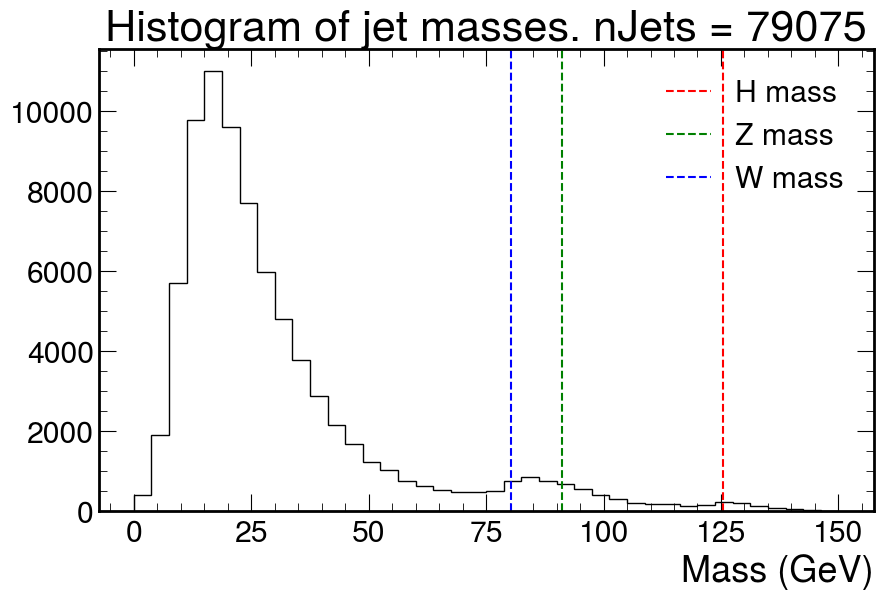

In [190]:
plotJetMasses(masses)

In [191]:
massesCalculated = np.load("GenMasses.npy")

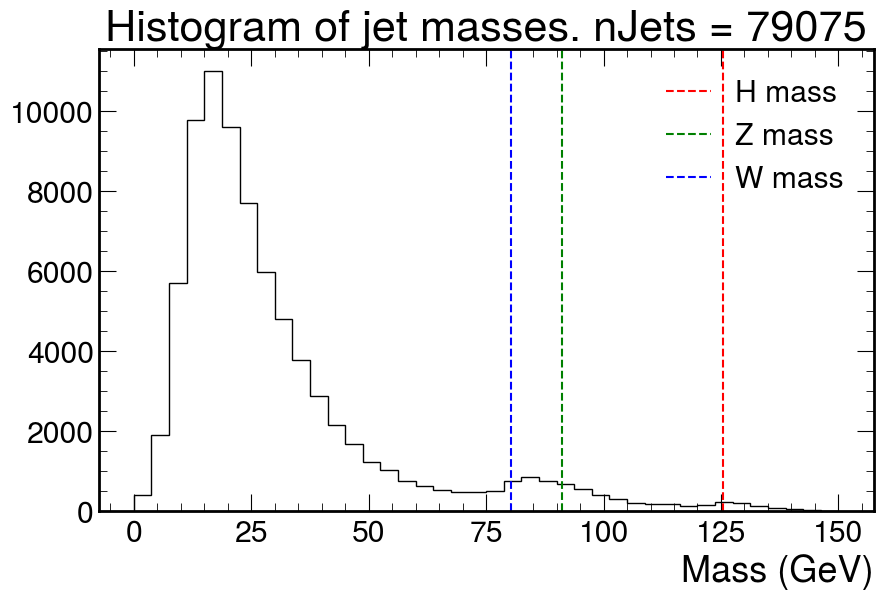

In [192]:
plotJetMasses(massesCalculated)

In [215]:
bkgMasses = readData("/shared/scratch/wq22321/wideCone/bkg/bkg.root")

In [216]:
bkgMasses = genMassGetter(data=bkgMasses)

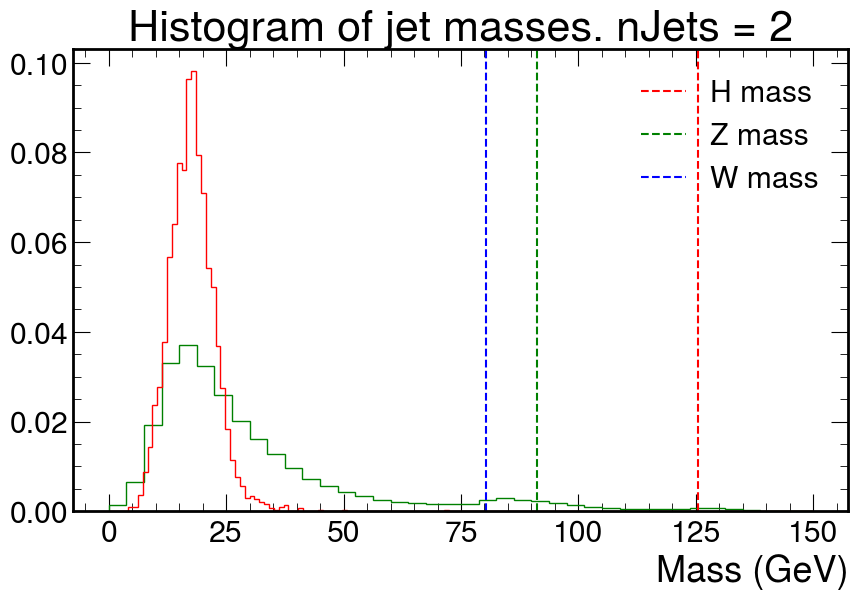

In [227]:
plotJetMasses((masses, bkgMasses))